# BitPredict Project: Time Series Forecasting

Predicting the price of bitcoin based on its historical price.

## Preparation

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import os
from sklearn.model_selection import train_test_split

Helper functions

In [2]:
WINDOW_SIZE = 7
HORIZON = 1

In [3]:
def mean_absolute_scaled_error(y_true,y_pred):
  """
  implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1])) # our seasonality is 1 day, hence the shift of 1

  return mae/mae_naive_no_season
  

In [4]:
def evaluate_preds(y_true,y_pred):
  y_true = tf.cast(y_true,tf.float32)
  y_pred = tf.cast(y_pred,tf.float32)
  result = {}
  result["MAE"] = tf.metrics.mean_absolute_error(y_true,y_pred).numpy()
  result["MAPE"] = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred).numpy()
  result["MASE"] = mean_absolute_scaled_error(y_true,y_pred).numpy()
  result["MSE"] = tf.metrics.mean_squared_error(y_true,y_pred).numpy()
  result["RMSE"] = tf.sqrt(tf.metrics.mean_squared_error(y_true,y_pred)).numpy()
  return result
  

In [5]:
def make_preds(model,input_data):
  """
  uses model to make predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions


In [6]:
def get_labeled_windows(x,horizon=HORIZON):
  """
  creates labels for windowed dataset.
  
  e.g. if horizon = 1
  input: [0,1,2,3,4,5,6,7] -> output: ([0,1,2,3,4,5,6],[7])
  input: [1,2,3,4,5,6,7,8] -> output: ([1,2,3,4,5,6,7],[8])
  input: [2,3,4,5,6,7,8,9] -> output: ([2,3,4,5,6,7,8],[9])
  """
  return (x[:,:-horizon],x[:,-horizon:])


In [7]:
def make_windows(x,window_size=WINDOW_SIZE,horizon=HORIZON):
  """
  turns a 1d array into a 2d array of sequential labeled windows of 
  window_size with horizon size labels.
  """
  # 1. create a window of specified window_size 
  # (add the horizon on the end for labeling later)
  window_step = np.expand_dims(np.arange(window_size+horizon),axis=0)
  # print(f"window_step:\n{window_step}")

  # 2. use numpy indexing to create a 2d array of multiple window steps
  # (minus 1 to account for 0 indexing)
  window_indices = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T # create 2D array of windows of size window_size
  # print(f"window indices:\n{window_indices,window_indices.shape}")

  # print(f"that expand dims:\n {np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T}")

  # 3. index on the target array (a time series) with 2d array of multiple window steps
  windowed_array = x[window_indices]
  # print(windowed_array)

  # 4. get the labeled windows
  test_window,test_label = get_labeled_windows(windowed_array,horizon=horizon)
  return test_window,test_label


In [8]:
def make_train_test_splits(windows,labels,test_split=0.2):
  """
  splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows)*(1-test_split)) # this will default to 80% train, 20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows,test_windows,train_labels,test_labels
  

In [9]:
def create_model_checkpoint(model_name,save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),
                                            verbose=0,
                                            monitor="val_loss",
                                            save_best_only=True)
  

In [35]:
def get_future_dates(start_date,into_future,offset=1):
  """
  returns array of datetime values ranging from start_date 
  to start_date + into_future
  """
  start_date = start_date + np.timedelta64(offset,"D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future,"D") # specify end date
  return np.arange(start_date,end_date,dtype="datetime64[D]") # return a date range between start and end date
  

## BTC price forecasting (with test dataset)

Retrieve data

In [10]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

# read in bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas col 1 is datetime

bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})

# get bitcoin date and price arrays
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

--2023-03-02 00:14:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.003s  

2023-03-02 00:14:07 (57.0 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



Create train and test sets

In [11]:
# create test and test splits the right way for time series data
split_size = int(0.8*len(prices)) # 80% train, 20% test

# create train data splits (everything before split)
X_train,y_train = timesteps[:split_size],prices[:split_size]

# create test data splits (everything after split)
X_test,y_test = timesteps[split_size:],prices[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2229, 2229, 558, 558)

Create windowed data, to consider a window of prior BTC price values (preceding projection)

In [12]:
# create train and test windows
full_windows,full_labels = make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)

Design, compile, train, and evaluate a simple model

In [13]:
model_BTC = tf.keras.models.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON,activation="linear") # or just leave activation unspecified
],name="model_BTC")

# compile
model_BTC.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ["mae","mse"])

# fit
history_1 = model_BTC.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint("model_BTC")])

model_BTC.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 565.5221 - mae: 565.5221 - mse: 1144265.7500


[565.5220947265625, 565.5220947265625, 1144265.75]

Create normalized windowed data, to consider a window of prior BTC price values (preceding projection)

In [14]:
# create train and test windows
full_windows_norm,full_labels_norm = make_windows(prices/max(prices),window_size=WINDOW_SIZE,horizon=HORIZON)
train_windows_norm,test_windows_norm,train_labels_norm,test_labels_norm = make_train_test_splits(full_windows_norm,full_labels_norm)

Design, compile, train, and evaluate a simple model with normalized data

In [15]:
model_BTC_norm = tf.keras.models.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON,activation="linear") # or just leave activation unspecified
],name="model_BTC_norm")

# compile
model_BTC_norm.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ["mae","mse"])

# fit
history_BTC_norm = model_BTC_norm.fit(x=train_windows_norm,
            y=train_labels_norm,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows_norm,test_labels_norm),
            callbacks=[create_model_checkpoint("model_BTC_norm")])

model_BTC_norm.evaluate(test_windows_norm,test_labels_norm)

18/18 [==============================] - 0s 3ms/step - loss: 0.0098 - mae: 0.0098 - mse: 3.3405e-04


[0.00978706032037735, 0.00978706032037735, 0.0003340468683745712]

## Set up a search for the best window size

In [16]:
# 3. set up a series of experiments to find whether or not there's a 
# better window size. 
tf.random.set_seed(42)

# train 10 different models with HORIZON=1 
# but with window size ranging from 2-12.
HORIZON = 1
window_size_models = []
window_size_results = {}

for ws in range(2,13):
  WINDOW_SIZE = ws

  model_window_size = tf.keras.models.Sequential([
      layers.Dense(128,activation="relu"),
      layers.Dense(HORIZON)
  ],name="model_window_size")

  # compile
  model_window_size.compile(loss="mae",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics = ["mae","mse"])

  # need to redefine data in accordance with window size, then re-fit
  full_windows_search,full_labels_search = make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
  train_windows_search,test_windows_search,train_labels_search,test_labels_search = make_train_test_splits(full_windows_search,full_labels_search)

  # fit
  model_window_size.fit(x=train_windows_search,
                        y=train_labels_search,
                        epochs=100,
                        verbose=0,
                        batch_size=128,
                        validation_data=(test_windows_search,test_labels_search),
                        callbacks=[create_model_checkpoint(f"model_window_size_{ws}")])
  
  model_window_size = tf.keras.models.load_model(f"model_experiments/model_window_size_{ws}/")
  model_window_size_results_preds = make_preds(model_window_size,test_windows_search)
  model_window_size_results = evaluate_preds(y_true=tf.squeeze(test_labels_search),
                                             y_pred=model_window_size_results_preds)
  
  window_size_models.append(model_window_size)
  window_size_results[f"model_window_size_{ws}"] = model_window_size_results

window_size_df = pd.DataFrame(window_size_results)

18/18 [==============================] - 0s 2ms/step


18/18 [==============================] - 0s 2ms/step


18/18 [==============================] - 0s 2ms/step


18/18 [==============================] - 0s 3ms/step


18/18 [==============================] - 0s 2ms/step


18/18 [==============================] - 0s 2ms/step


18/18 [==============================] - 0s 2ms/step


18/18 [==============================] - 0s 2ms/step


18/18 [==============================] - 0s 2ms/step


18/18 [==============================] - 0s 2ms/step


18/18 [==============================] - 0s 2ms/step


## Look at multiple variable influences in up-to-date BTC and DOGE price datasets

Extract BTC price history

In [22]:
# get the most up-to-date data on bitcoin (our data goes up to 5/18/21).

# you can download the Bitcoin historical data for free from 
# coindesk.com/price/bitcoin and clicking "Export Data" -> "CSV".
"""
> https://finance.yahoo.com/quote/BTC-USD/history?period1=1410825600&period2=1676505600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
"""

# read in bitcoin data and parse the dates
BTC_df_up_to_date = pd.read_csv("/content/BTC-USD.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas col 1 is datetime

bitcoin_prices_up_to_date = pd.DataFrame(BTC_df_up_to_date["Close"]).rename(columns={"Close":"Price"})

BTC_timesteps_up_to_date = bitcoin_prices_up_to_date.index.to_numpy()
BTC_prices_up_to_date = bitcoin_prices_up_to_date["Price"].to_numpy()

Include another feature (DOGE coin price), to examine multivariance

In [19]:
# 5. for our multivariate modeling experiment, we added the bitcoin 
# block reward size as an extra feature to make our time series multi-
# variate. 

# are there any other features you think you could add?
"""
> DOGE COIN value
"""

# read in doge data and parse the dates
DOGE_df_up_to_date = pd.read_csv("/content/DOGE-USD.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas col 1 is datetime

DOGE_prices_up_to_date = pd.DataFrame(DOGE_df_up_to_date["Close"]).rename(columns={"Close":"Price"})

DOGE_timesteps_up_to_date = DOGE_prices_up_to_date.index.to_numpy()
DOGE_doge_prices_up_to_date = DOGE_prices_up_to_date["Price"].to_numpy()

In [23]:
len(DOGE_doge_prices_up_to_date), len(BTC_prices_up_to_date)

(1926, 3075)

Truncate BTC and DOGE datasets to cover the same timeframe

In [24]:
BTC_timesteps_up_to_date_mod = BTC_timesteps_up_to_date[3075-1926:]
BTC_prices_up_to_date_mod = BTC_prices_up_to_date[3075-1926:]

Create a combined pd.DataFrame

In [25]:
# add in block_reward values to our dataframe
bitcoin_prices_DOGE = bitcoin_prices_up_to_date.copy()
bitcoin_prices_DOGE = bitcoin_prices_DOGE[3075-1926:]
bitcoin_prices_DOGE["DOGE"] = DOGE_doge_prices_up_to_date

bitcoin_prices_DOGE_windowed = bitcoin_prices_DOGE.copy()

Add windowed columns, to consider a window of prior BTC price values (preceding projection)

In [26]:
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_DOGE_windowed[f"Price+{i+1}"] = bitcoin_prices_DOGE_windowed["Price"].shift(periods=i+1)
bitcoin_prices_DOGE_windowed[:5]

,Price,DOGE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7,Price+8,Price+9,Price+10,Price+11,Price+12
Date,,,,,,,,,,,,,,
2017-11-09,7143.580078,0.001415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-10,6618.140137,0.001163,7143.580078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-11,6357.600098,0.001201,6618.140137,7143.580078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-12,5950.069824,0.001038,6357.600098,6618.140137,7143.580078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-13,6559.490234,0.001211,5950.069824,6357.600098,6618.140137,7143.580078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create train and test sets

In [27]:
# create X (window and DOGE price) and y (horizon) features
X = bitcoin_prices_DOGE_windowed.dropna().drop("Price",axis=1).astype(np.float32).to_numpy()
y = bitcoin_prices_DOGE_windowed.dropna()["Price"].astype(np.float32).to_numpy()

# make train and test sets using indexing
split_size = int(len(X)*0.8)
X_train_multi,y_train_multi = X[:split_size],y[:split_size]
X_test_multi,y_test_multi = X[split_size:],y[split_size:]

Design, compile, train, and evaluate a simple model

In [28]:
model_BTC_DOGE = tf.keras.models.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON)
],name="model_BTC_DOGE")

model_BTC_DOGE.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

model_BTC_DOGE.fit(x=X_train_multi,
                   y=y_train_multi,
                   epochs=100,
                   batch_size=128,
                   validation_data=(X_test_multi,y_test_multi),
                   callbacks=[create_model_checkpoint("model_BTC_DOGE")])

model_BTC_DOGE.evaluate(X_test_multi,y_test_multi)

Epoch 1/100
 1/12 [=>............................] - ETA: 14s - loss: 16847.5664 - mae: 16847.5664 - mse: 534492352.0000

12/12 [==============================] - 2s 70ms/step - loss: 7600.5815 - mae: 7600.5815 - mse: 163491360.0000 - val_loss: 6007.7178 - val_mae: 6007.7178 - val_mse: 46574268.0000
Epoch 2/100
 1/12 [=>............................] - ETA: 0s - loss: 4293.4375 - mae: 4293.4375 - mse: 42752176.0000

12/12 [==============================] - 1s 55ms/step - loss: 2865.1179 - mae: 2865.1179 - mse: 22825956.0000 - val_loss: 2991.2229 - val_mae: 2991.2229 - val_mse: 12772213.0000
Epoch 3/100
 1/12 [=>............................] - ETA: 0s - loss: 2742.4619 - mae: 2742.4619 - mse: 18706830.0000

12/12 [==============================] - 1s 71ms/step - loss: 1746.1179 - mae: 1746.1179 - mse: 8545045.0000 - val_loss: 2145.6919 - val_mae: 2145.6919 - val_mse: 8298287.5000
Epoch 4/100
 1/12 [=>............................] - ETA: 0s - loss: 1339.6470 - mae: 1339.6470 - mse: 5139732.5000

12/12 [==============================] - 1s 85ms/step - loss: 1412.8494 - mae: 1412.8494 - mse: 5890354.0000 - val_loss: 1569.0571 - val_mae: 1569.0571 - val_mse: 5046640.5000
Epoch 5/100
 1/12 [=>............................] - ETA: 0s - loss: 1297.3745 - mae: 1297.3745 - mse: 4282331.0000

12/12 [==============================] - 1s 80ms/step - loss: 1311.4714 - mae: 1311.4714 - mse: 5239282.5000 - val_loss: 1378.7465 - val_mae: 1378.7465 - val_mse: 3965973.7500
Epoch 6/100
 1/12 [=>............................] - ETA: 0s - loss: 1183.5204 - mae: 1183.5204 - mse: 4787673.0000

12/12 [==============================] - 1s 55ms/step - loss: 1226.7192 - mae: 1226.7192 - mse: 4579843.5000 - val_loss: 1320.6333 - val_mae: 1320.6333 - val_mse: 3684670.5000
Epoch 7/100
 1/12 [=>............................] - ETA: 0s - loss: 1108.6204 - mae: 1108.6204 - mse: 3724011.0000

12/12 [==============================] - 1s 54ms/step - loss: 1186.4644 - mae: 1186.4644 - mse: 4333645.5000 - val_loss: 1266.1572 - val_mae: 1266.1572 - val_mse: 3440923.0000
Epoch 8/100
12/12 [==============================] - 0s 7ms/step - loss: 1123.7224 - mae: 1123.7224 - mse: 3859933.7500 - val_loss: 1273.1569 - val_mae: 1273.1569 - val_mse: 3437788.5000
Epoch 9/100
12/12 [==============================] - 0s 6ms/step - loss: 1080.9808 - mae: 1080.9808 - mse: 3594070.2500 - val_loss: 1289.4647 - val_mae: 1289.4647 - val_mse: 3428938.2500
Epoch 10/100
 1/12 [=>............................] - ETA: 0s - loss: 1204.5480 - mae: 1204.5480 - mse: 4144497.0000

12/12 [==============================] - 1s 53ms/step - loss: 1061.9246 - mae: 1061.9246 - mse: 3444627.0000 - val_loss: 1147.6039 - val_mae: 1147.6039 - val_mse: 2862199.7500
Epoch 11/100
 1/12 [=>............................] - ETA: 0s - loss: 802.7476 - mae: 802.7476 - mse: 1864802.1250

12/12 [==============================] - 1s 77ms/step - loss: 1004.8412 - mae: 1004.8412 - mse: 3111804.5000 - val_loss: 1081.7722 - val_mae: 1081.7722 - val_mse: 2568246.7500
Epoch 12/100
 1/12 [=>............................] - ETA: 0s - loss: 854.6807 - mae: 854.6807 - mse: 1958199.0000

12/12 [==============================] - 1s 79ms/step - loss: 960.7233 - mae: 960.7233 - mse: 2851677.2500 - val_loss: 1061.3170 - val_mae: 1061.3170 - val_mse: 2461334.0000
Epoch 13/100
12/12 [==============================] - ETA: 0s - loss: 918.3233 - mae: 918.3233 - mse: 2602312.5000

12/12 [==============================] - 1s 67ms/step - loss: 918.3233 - mae: 918.3233 - mse: 2602312.5000 - val_loss: 1015.9954 - val_mae: 1015.9954 - val_mse: 2263455.0000
Epoch 14/100
 1/12 [=>............................] - ETA: 0s - loss: 907.5574 - mae: 907.5574 - mse: 2894178.5000

12/12 [==============================] - 1s 52ms/step - loss: 885.2652 - mae: 885.2652 - mse: 2420236.7500 - val_loss: 963.8331 - val_mae: 963.8331 - val_mse: 2060216.3750
Epoch 15/100
 1/12 [=>............................] - ETA: 0s - loss: 948.4528 - mae: 948.4528 - mse: 2835084.5000

12/12 [==============================] - 1s 52ms/step - loss: 851.4496 - mae: 851.4496 - mse: 2294424.5000 - val_loss: 963.6190 - val_mae: 963.6190 - val_mse: 1984822.7500
Epoch 16/100
12/12 [==============================] - 0s 6ms/step - loss: 853.1160 - mae: 853.1160 - mse: 2197407.7500 - val_loss: 984.6968 - val_mae: 984.6968 - val_mse: 2066222.2500
Epoch 17/100
 1/12 [=>............................] - ETA: 0s - loss: 724.3796 - mae: 724.3796 - mse: 1828373.3750

12/12 [==============================] - 1s 52ms/step - loss: 811.4766 - mae: 811.4766 - mse: 2068979.0000 - val_loss: 931.7059 - val_mae: 931.7059 - val_mse: 1898847.2500
Epoch 18/100
12/12 [==============================] - 0s 7ms/step - loss: 807.2758 - mae: 807.2758 - mse: 1989403.0000 - val_loss: 1022.8607 - val_mae: 1022.8607 - val_mse: 2125208.5000
Epoch 19/100
 1/12 [=>............................] - ETA: 0s - loss: 852.6931 - mae: 852.6931 - mse: 2466144.2500

12/12 [==============================] - 1s 55ms/step - loss: 787.6418 - mae: 787.6418 - mse: 1940762.3750 - val_loss: 868.4247 - val_mae: 868.4247 - val_mse: 1629424.5000
Epoch 20/100
 1/12 [=>............................] - ETA: 0s - loss: 788.3402 - mae: 788.3402 - mse: 1939260.2500

12/12 [==============================] - 1s 52ms/step - loss: 783.4669 - mae: 783.4669 - mse: 1845801.1250 - val_loss: 845.7823 - val_mae: 845.7823 - val_mse: 1586936.8750
Epoch 21/100
12/12 [==============================] - 0s 6ms/step - loss: 755.9076 - mae: 755.9076 - mse: 1793637.2500 - val_loss: 1116.2063 - val_mae: 1116.2063 - val_mse: 2368706.0000
Epoch 22/100
12/12 [==============================] - 0s 6ms/step - loss: 798.4913 - mae: 798.4913 - mse: 1991852.5000 - val_loss: 923.5013 - val_mae: 923.5013 - val_mse: 1687802.8750
Epoch 23/100
 1/12 [=>............................] - ETA: 0s - loss: 861.3115 - mae: 861.3115 - mse: 2178782.5000

12/12 [==============================] - 1s 81ms/step - loss: 733.8778 - mae: 733.8778 - mse: 1691284.1250 - val_loss: 828.5764 - val_mae: 828.5764 - val_mse: 1506725.8750
Epoch 24/100
 1/12 [=>............................] - ETA: 0s - loss: 872.6266 - mae: 872.6266 - mse: 2094225.8750

12/12 [==============================] - 1s 56ms/step - loss: 727.3846 - mae: 727.3846 - mse: 1633527.7500 - val_loss: 820.3005 - val_mae: 820.3005 - val_mse: 1470857.7500
Epoch 25/100
 1/12 [=>............................] - ETA: 0s - loss: 662.3562 - mae: 662.3562 - mse: 1588776.8750

12/12 [==============================] - 1s 58ms/step - loss: 715.5255 - mae: 715.5255 - mse: 1598273.3750 - val_loss: 812.0499 - val_mae: 812.0499 - val_mse: 1427435.0000
Epoch 26/100
12/12 [==============================] - 0s 7ms/step - loss: 710.4662 - mae: 710.4662 - mse: 1623182.5000 - val_loss: 815.1615 - val_mae: 815.1615 - val_mse: 1447061.0000
Epoch 27/100
12/12 [==============================] - 0s 7ms/step - loss: 738.0832 - mae: 738.0832 - mse: 1704491.3750 - val_loss: 993.1929 - val_mae: 993.1929 - val_mse: 1953938.5000
Epoch 28/100
 1/12 [=>............................] - ETA: 0s - loss: 790.2289 - mae: 790.2289 - mse: 1772419.2500

12/12 [==============================] - 1s 55ms/step - loss: 724.2626 - mae: 724.2626 - mse: 1631640.8750 - val_loss: 797.3529 - val_mae: 797.3529 - val_mse: 1383741.3750
Epoch 29/100
12/12 [==============================] - 0s 6ms/step - loss: 679.5922 - mae: 679.5922 - mse: 1496669.8750 - val_loss: 802.3469 - val_mae: 802.3469 - val_mse: 1399447.0000
Epoch 30/100
12/12 [==============================] - 0s 7ms/step - loss: 685.4308 - mae: 685.4308 - mse: 1529376.7500 - val_loss: 846.1733 - val_mae: 846.1733 - val_mse: 1525673.6250
Epoch 31/100
12/12 [==============================] - 0s 7ms/step - loss: 691.4376 - mae: 691.4376 - mse: 1514116.5000 - val_loss: 828.3522 - val_mae: 828.3522 - val_mse: 1403659.8750
Epoch 32/100
12/12 [==============================] - 0s 6ms/step - loss: 700.3120 - mae: 700.3120 - mse: 1530678.2500 - val_loss: 885.6303 - val_mae: 885.6303 - val_mse: 1538359.7500
Epoch 33/100
 1/12 [=>............................] - ETA: 0s - loss: 704.5129 - mae: 704.51

12/12 [==============================] - 1s 53ms/step - loss: 687.3022 - mae: 687.3022 - mse: 1463777.5000 - val_loss: 785.1996 - val_mae: 785.1996 - val_mse: 1344248.3750
Epoch 34/100
 1/12 [=>............................] - ETA: 0s - loss: 739.5134 - mae: 739.5134 - mse: 1744937.7500

12/12 [==============================] - 1s 55ms/step - loss: 656.4046 - mae: 656.4046 - mse: 1405679.1250 - val_loss: 765.7117 - val_mae: 765.7117 - val_mse: 1279942.1250
Epoch 35/100
12/12 [==============================] - 0s 6ms/step - loss: 648.4818 - mae: 648.4818 - mse: 1385818.3750 - val_loss: 870.9295 - val_mae: 870.9295 - val_mse: 1588332.6250
Epoch 36/100
12/12 [==============================] - 0s 6ms/step - loss: 688.1453 - mae: 688.1453 - mse: 1517558.1250 - val_loss: 774.7577 - val_mae: 774.7577 - val_mse: 1313109.0000
Epoch 37/100
 1/12 [=>............................] - ETA: 0s - loss: 711.7762 - mae: 711.7762 - mse: 1645574.2500

12/12 [==============================] - 1s 53ms/step - loss: 661.2753 - mae: 661.2753 - mse: 1414736.5000 - val_loss: 754.3983 - val_mae: 754.3983 - val_mse: 1256536.1250
Epoch 38/100
 1/12 [=>............................] - ETA: 0s - loss: 630.0094 - mae: 630.0094 - mse: 1012514.6875

12/12 [==============================] - 1s 56ms/step - loss: 641.2329 - mae: 641.2329 - mse: 1340046.5000 - val_loss: 746.5060 - val_mae: 746.5060 - val_mse: 1231372.5000
Epoch 39/100
12/12 [==============================] - 0s 6ms/step - loss: 644.8687 - mae: 644.8687 - mse: 1367105.2500 - val_loss: 783.0237 - val_mae: 783.0237 - val_mse: 1282382.0000
Epoch 40/100
12/12 [==============================] - 0s 7ms/step - loss: 638.3777 - mae: 638.3777 - mse: 1288784.6250 - val_loss: 965.9017 - val_mae: 965.9017 - val_mse: 1812234.7500
Epoch 41/100
 1/12 [=>............................] - ETA: 0s - loss: 829.7576 - mae: 829.7576 - mse: 1861464.2500

12/12 [==============================] - 1s 73ms/step - loss: 694.2290 - mae: 694.2290 - mse: 1545176.8750 - val_loss: 735.8528 - val_mae: 735.8528 - val_mse: 1203531.8750
Epoch 42/100
12/12 [==============================] - 0s 9ms/step - loss: 671.6671 - mae: 671.6671 - mse: 1446806.2500 - val_loss: 764.1183 - val_mae: 764.1183 - val_mse: 1236046.1250
Epoch 43/100
12/12 [==============================] - 0s 8ms/step - loss: 653.9288 - mae: 653.9288 - mse: 1368908.0000 - val_loss: 885.7175 - val_mae: 885.7175 - val_mse: 1508230.5000
Epoch 44/100
12/12 [==============================] - 0s 10ms/step - loss: 704.8387 - mae: 704.8387 - mse: 1552019.2500 - val_loss: 741.4949 - val_mae: 741.4949 - val_mse: 1223258.6250
Epoch 45/100
12/12 [==============================] - 0s 11ms/step - loss: 639.4938 - mae: 639.4938 - mse: 1334975.8750 - val_loss: 764.3973 - val_mae: 764.3973 - val_mse: 1285541.6250
Epoch 46/100
12/12 [==============================] - 0s 11ms/step - loss: 668.5117 - mae:

12/12 [==============================] - 1s 83ms/step - loss: 616.3851 - mae: 616.3851 - mse: 1260839.7500 - val_loss: 727.5135 - val_mae: 727.5135 - val_mse: 1185683.0000
Epoch 50/100
 1/12 [=>............................] - ETA: 0s - loss: 684.5685 - mae: 684.5685 - mse: 1541774.2500

12/12 [==============================] - 1s 54ms/step - loss: 616.3899 - mae: 616.3899 - mse: 1263508.2500 - val_loss: 726.6309 - val_mae: 726.6309 - val_mse: 1150195.5000
Epoch 51/100
12/12 [==============================] - 0s 8ms/step - loss: 624.4059 - mae: 624.4059 - mse: 1291170.7500 - val_loss: 820.9360 - val_mae: 820.9360 - val_mse: 1344736.8750
Epoch 52/100
12/12 [==============================] - 0s 6ms/step - loss: 663.8753 - mae: 663.8753 - mse: 1391565.6250 - val_loss: 791.1686 - val_mae: 791.1686 - val_mse: 1340801.3750
Epoch 53/100
 1/12 [=>............................] - ETA: 0s - loss: 662.2714 - mae: 662.2714 - mse: 1483465.6250

12/12 [==============================] - 1s 52ms/step - loss: 623.5570 - mae: 623.5570 - mse: 1236035.8750 - val_loss: 711.1670 - val_mae: 711.1670 - val_mse: 1122289.5000
Epoch 54/100
 1/12 [=>............................] - ETA: 0s - loss: 525.3728 - mae: 525.3728 - mse: 1005509.5625

12/12 [==============================] - 1s 52ms/step - loss: 634.1666 - mae: 634.1666 - mse: 1317892.0000 - val_loss: 707.9574 - val_mae: 707.9574 - val_mse: 1133996.5000
Epoch 55/100
12/12 [==============================] - 0s 6ms/step - loss: 612.2446 - mae: 612.2446 - mse: 1223310.5000 - val_loss: 847.3941 - val_mae: 847.3941 - val_mse: 1473050.8750
Epoch 56/100
12/12 [==============================] - 0s 7ms/step - loss: 641.1147 - mae: 641.1147 - mse: 1366874.3750 - val_loss: 720.6240 - val_mae: 720.6240 - val_mse: 1169080.3750
Epoch 57/100
12/12 [==============================] - 0s 7ms/step - loss: 618.0776 - mae: 618.0776 - mse: 1250442.3750 - val_loss: 980.1735 - val_mae: 980.1735 - val_mse: 1795873.7500
Epoch 58/100
12/12 [==============================] - 0s 6ms/step - loss: 668.3470 - mae: 668.3470 - mse: 1397361.2500 - val_loss: 860.2003 - val_mae: 860.2003 - val_mse: 1418537.5000
Epoch 59/100
12/12 [==============================] - 0s 7ms/step - loss: 656.7609 - mae: 65

12/12 [==============================] - 1s 56ms/step - loss: 696.7649 - mae: 696.7649 - mse: 1510772.5000 - val_loss: 703.3096 - val_mae: 703.3096 - val_mse: 1097910.1250
Epoch 61/100
 1/12 [=>............................] - ETA: 0s - loss: 505.7295 - mae: 505.7295 - mse: 833359.1250

12/12 [==============================] - 1s 51ms/step - loss: 629.0453 - mae: 629.0453 - mse: 1329374.8750 - val_loss: 693.2790 - val_mae: 693.2790 - val_mse: 1097166.0000
Epoch 62/100
12/12 [==============================] - 0s 6ms/step - loss: 616.2230 - mae: 616.2230 - mse: 1278255.0000 - val_loss: 697.2537 - val_mae: 697.2537 - val_mse: 1087368.7500
Epoch 63/100
 1/12 [=>............................] - ETA: 0s - loss: 561.5380 - mae: 561.5380 - mse: 1227937.7500

12/12 [==============================] - 1s 55ms/step - loss: 597.0812 - mae: 597.0812 - mse: 1195681.7500 - val_loss: 690.5627 - val_mae: 690.5627 - val_mse: 1091284.5000
Epoch 64/100
 1/12 [=>............................] - ETA: 0s - loss: 694.3340 - mae: 694.3340 - mse: 1626281.2500

12/12 [==============================] - 1s 80ms/step - loss: 596.3945 - mae: 596.3945 - mse: 1213125.5000 - val_loss: 686.7144 - val_mae: 686.7144 - val_mse: 1081207.5000
Epoch 65/100
12/12 [==============================] - 0s 8ms/step - loss: 591.1841 - mae: 591.1841 - mse: 1170018.5000 - val_loss: 728.0133 - val_mae: 728.0133 - val_mse: 1132249.6250
Epoch 66/100
12/12 [==============================] - 0s 7ms/step - loss: 627.1296 - mae: 627.1296 - mse: 1243155.7500 - val_loss: 778.2977 - val_mae: 778.2977 - val_mse: 1231906.5000
Epoch 67/100
12/12 [==============================] - 0s 6ms/step - loss: 620.1213 - mae: 620.1213 - mse: 1240028.6250 - val_loss: 779.7551 - val_mae: 779.7551 - val_mse: 1233629.6250
Epoch 68/100
 1/12 [=>............................] - ETA: 0s - loss: 752.5000 - mae: 752.5000 - mse: 1814996.0000

12/12 [==============================] - 1s 55ms/step - loss: 616.6928 - mae: 616.6928 - mse: 1249881.2500 - val_loss: 680.2090 - val_mae: 680.2090 - val_mse: 1059978.8750
Epoch 69/100
12/12 [==============================] - 0s 7ms/step - loss: 587.7157 - mae: 587.7157 - mse: 1160700.6250 - val_loss: 711.3616 - val_mae: 711.3616 - val_mse: 1142466.8750
Epoch 70/100
12/12 [==============================] - 0s 7ms/step - loss: 586.3961 - mae: 586.3961 - mse: 1170005.6250 - val_loss: 711.8177 - val_mae: 711.8177 - val_mse: 1098993.7500
Epoch 71/100
12/12 [==============================] - 0s 7ms/step - loss: 591.8580 - mae: 591.8580 - mse: 1183012.8750 - val_loss: 703.8903 - val_mae: 703.8903 - val_mse: 1124660.6250
Epoch 72/100
12/12 [==============================] - 0s 8ms/step - loss: 584.6611 - mae: 584.6611 - mse: 1147687.0000 - val_loss: 688.0602 - val_mae: 688.0602 - val_mse: 1088369.2500
Epoch 73/100
12/12 [==============================] - 0s 8ms/step - loss: 578.3108 - mae: 57

12/12 [==============================] - 1s 56ms/step - loss: 590.9444 - mae: 590.9444 - mse: 1189539.8750 - val_loss: 671.6310 - val_mae: 671.6310 - val_mse: 1045544.7500
Epoch 75/100
 1/12 [=>............................] - ETA: 0s - loss: 499.5615 - mae: 499.5615 - mse: 886440.6875

12/12 [==============================] - 1s 56ms/step - loss: 593.5516 - mae: 593.5516 - mse: 1167291.6250 - val_loss: 669.9801 - val_mae: 669.9801 - val_mse: 1039402.4375
Epoch 76/100
12/12 [==============================] - 0s 6ms/step - loss: 622.5386 - mae: 622.5386 - mse: 1280987.0000 - val_loss: 674.0046 - val_mae: 674.0046 - val_mse: 1037970.5625
Epoch 77/100
12/12 [==============================] - 0s 8ms/step - loss: 600.8257 - mae: 600.8257 - mse: 1188997.3750 - val_loss: 754.5823 - val_mae: 754.5823 - val_mse: 1231214.0000
Epoch 78/100
12/12 [==============================] - 0s 7ms/step - loss: 583.7249 - mae: 583.7249 - mse: 1144973.0000 - val_loss: 679.3086 - val_mae: 679.3086 - val_mse: 1042437.3750
Epoch 79/100
12/12 [==============================] - 0s 6ms/step - loss: 585.4357 - mae: 585.4357 - mse: 1170932.6250 - val_loss: 684.0993 - val_mae: 684.0993 - val_mse: 1080057.8750
Epoch 80/100
12/12 [==============================] - 0s 6ms/step - loss: 577.5067 - mae: 57

12/12 [==============================] - 1s 55ms/step - loss: 575.5609 - mae: 575.5609 - mse: 1148688.2500 - val_loss: 659.1550 - val_mae: 659.1550 - val_mse: 1022076.4375
Epoch 86/100
12/12 [==============================] - 0s 6ms/step - loss: 591.7003 - mae: 591.7003 - mse: 1172677.7500 - val_loss: 734.2969 - val_mae: 734.2969 - val_mse: 1127896.6250
Epoch 87/100
12/12 [==============================] - 0s 8ms/step - loss: 675.8021 - mae: 675.8021 - mse: 1438598.8750 - val_loss: 938.4437 - val_mae: 938.4437 - val_mse: 1575133.7500
Epoch 88/100
12/12 [==============================] - 0s 6ms/step - loss: 620.3893 - mae: 620.3893 - mse: 1248064.3750 - val_loss: 690.3710 - val_mae: 690.3710 - val_mse: 1051295.8750
Epoch 89/100
12/12 [==============================] - 0s 6ms/step - loss: 664.7858 - mae: 664.7858 - mse: 1372339.5000 - val_loss: 893.7169 - val_mae: 893.7169 - val_mse: 1532097.8750
Epoch 90/100
12/12 [==============================] - 0s 7ms/step - loss: 596.2896 - mae: 59

12/12 [==============================] - 1s 75ms/step - loss: 571.5312 - mae: 571.5312 - mse: 1116088.7500 - val_loss: 657.3171 - val_mae: 657.3171 - val_mse: 1022223.9375
Epoch 93/100
12/12 [==============================] - 0s 10ms/step - loss: 566.2542 - mae: 566.2542 - mse: 1118028.8750 - val_loss: 671.6350 - val_mae: 671.6350 - val_mse: 1020852.3125
Epoch 94/100
12/12 [==============================] - ETA: 0s - loss: 583.2045 - mae: 583.2045 - mse: 1135015.7500

12/12 [==============================] - 1s 84ms/step - loss: 583.2045 - mae: 583.2045 - mse: 1135015.7500 - val_loss: 653.3855 - val_mae: 653.3855 - val_mse: 1013089.7500
Epoch 95/100
12/12 [==============================] - 0s 10ms/step - loss: 582.8710 - mae: 582.8710 - mse: 1132780.6250 - val_loss: 683.1331 - val_mae: 683.1331 - val_mse: 1077054.5000
Epoch 96/100
12/12 [==============================] - 0s 9ms/step - loss: 575.7724 - mae: 575.7724 - mse: 1121211.6250 - val_loss: 858.6323 - val_mae: 858.6323 - val_mse: 1443292.3750
Epoch 97/100
12/12 [==============================] - 0s 11ms/step - loss: 597.5295 - mae: 597.5295 - mse: 1199793.1250 - val_loss: 719.9324 - val_mae: 719.9324 - val_mse: 1149745.7500
Epoch 98/100
12/12 [==============================] - 0s 10ms/step - loss: 568.6364 - mae: 568.6364 - mse: 1096448.6250 - val_loss: 713.7961 - val_mae: 713.7961 - val_mse: 1085317.3750
Epoch 99/100
12/12 [==============================] - 0s 7ms/step - loss: 581.0914 - mae:

[725.7393188476562, 725.7393188476562, 1106292.125]

Re-load the best weights (stored with ModelCheckpoint) and evaluate the model

In [29]:
# load in saved best-performing model and evaluate it on test data
model_BTC_DOGE = tf.keras.models.load_model("model_experiments/model_BTC_DOGE/")
model_BTC_DOGE.evaluate(X_test_multi,y_test_multi)

model_BTC_DOGE_preds = make_preds(model_BTC_DOGE,X_test_multi)
model_BTC_DOGE_results = evaluate_preds(y_true=tf.squeeze(y_test_multi),
                                        y_pred=model_BTC_DOGE_preds)

model_BTC_DOGE_results

12/12 [==============================] - 0s 2ms/step


{'MAE': 653.3856,
 'MAPE': 2.3893068,
 'MASE': 1.0761949,
 'MSE': 1013090.0,
 'RMSE': 1006.5237}

## BTC price forecasting (with model retraining)



Design and compile a simple model

In [30]:
forecast_model = tf.keras.models.Sequential([
    layers.Dense(128,kernel_initializer="he_normal",activation="relu"),
    layers.Dense(128,kernel_initializer="he_normal",activation="relu"),
    layers.Dense(HORIZON)
],name="forecast_model")

forecast_model.compile(loss="mae",
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=["mae"])

Create a function to call to iteratively predict to a specified forecast depth

In [31]:
def make_forecasts_retraining(model,data_input,forecast_depth,window_size=WINDOW_SIZE,horizon=1,epochs=100):
  # take in the model
  projection_record = data_input

  for i in range(forecast_depth):
    # recalculate all windows and labels
    all_windows,all_labels = make_windows(projection_record,window_size=window_size,horizon=horizon)

    # make combined dataset
    all_dataset_windows = tf.data.Dataset.from_tensor_slices(all_windows)
    all_dataset_labels = tf.data.Dataset.from_tensor_slices(all_labels)
    all_dataset = tf.data.Dataset.zip((all_dataset_windows,all_dataset_labels)) 
    all_dataset = all_dataset.batch(128).prefetch(tf.data.AUTOTUNE)

    # train the model on all of the data
    model.fit(all_dataset,
              epochs=epochs,
              verbose=0)

    # predict next value based on last WINDOW_SIZE price values
    predictor_window = projection_record[-WINDOW_SIZE:]
    next_prediction = model.predict(tf.expand_dims(predictor_window,axis=0))

    # add predicted price value to end of price list
    projection_record = np.append(projection_record,next_prediction)
  return projection_record

Predict to a specified forecast depth and view the result

In [32]:
projection_record = make_forecasts_retraining(model=forecast_model,
                                              data_input=prices,
                                              forecast_depth=100)

1/1 [==============================] - 0s 20ms/step


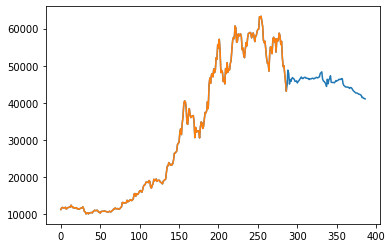

In [33]:
offset = 2500
plt.plot(projection_record[offset:])
plt.plot(prices[offset:])

Compare the results to actual future data (from the up-to-date BTC price dataset)

In [36]:
# last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
future_dates = get_future_dates(start_date=last_timestep,
                                into_future=100,
                                offset=1)

full_dates = np.append(timesteps,future_dates)

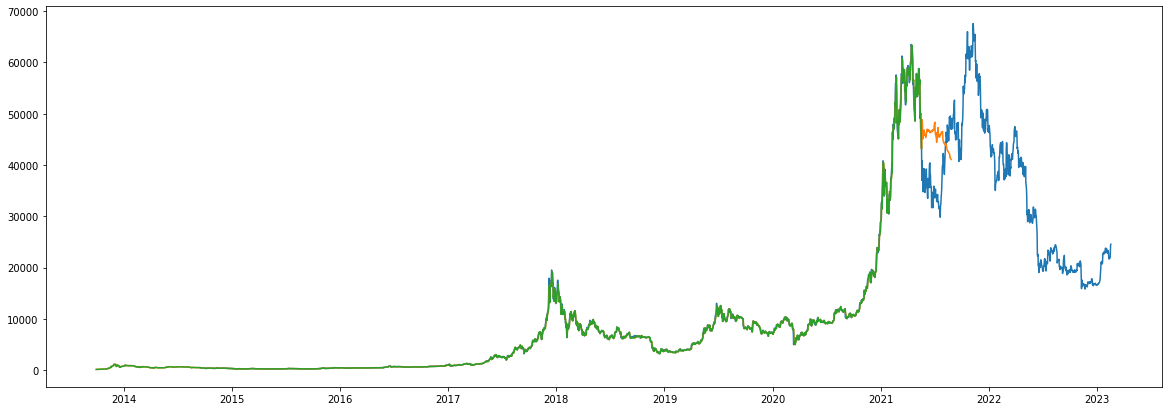

In [37]:
plt.figure(figsize=(20,7))
offset = 2500
plt.plot(timesteps_up_to_date,prices_up_to_date)
plt.plot(full_dates,projection_record)
plt.plot(timesteps,prices)